In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
import re

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import copy
from PIL import Image
from itertools import cycle


# for importing data
import torchvision
import os


In [13]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
import re

In [15]:
# All of the methods that we are using

def generat_OneHotEncoder(sequences, nolabel):
    
    # The LabelEncoder encodes a sequence of bases as a sequence of integers.
    integer_encoder = LabelEncoder()  
    # The OneHotEncoder converts an array of integers to a sparse matrix where 
    # each row corresponds to one possible value of each feature.
    one_hot_encoder = OneHotEncoder(categories='auto')   
    input_features = []

    
    if (nolabel):
        for sequence in sequences:
            integer_encoded = integer_encoder.fit_transform(list(sequence))
            integer_encoded = np.array(integer_encoded).reshape(-1, 1)
            one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
            input_features.append(one_hot_encoded.toarray())
        np.set_printoptions(threshold=40)
        input_features = np.stack(input_features)
        #print("Example sequence\n-----------------------")
        #print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
        #print('One hot encoding of Sequence #1:\n',input_features[0].T)
    else:
        labels = np.array(sequences).reshape(-1, 1)
        input_features = one_hot_encoder.fit_transform(labels).toarray()
        #print('Labels:\n',labels.T)
        #print('One-hot encoded labels:\n',input_features.T)
        
    return input_features


def convert_to_tensor_translate_into_dataloader(data, label):
    
    # NEW: reshape to 2D!
   # DNA_input_features_reshape_2D = DNA_input_features.reshape(DNA_input_features.shape[0],1,DNA_input_features.shape[1],DNA_input_features.shape[2])
   # print(DNA_input_features_reshape_2D.shape)
    # Step 1: convert to tensor
    dataT   = torch.tensor( data ).float()
    labelsT = torch.tensor( label ).float()

    # Step 2: use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.2)


    # Step 3: convert into PyTorch Datasets
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)

    # Step 4: translate into dataloader objects
    batchsize    = 32
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=32,drop_last=True)
    print("train_loader shape =  ",train_loader.dataset.tensors[0].shape)
    print("test_loader shape =  ",test_loader.dataset.tensors[0].shape)
    return train_loader,test_loader


# a function that trains DNA model

# input the network and the number of epochs to train
def function2trainDNA(net,train_loader,test_loader,numepochs=10):

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
    

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,dim=1) == torch.argmax(y,dim=1)     # booleans (false/true)    
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
        
        
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    
    # compute test accuracy
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net
 
    # ************************************************************** PSSM****************************************************************
 # these functions are related ot PSSM

def load_pssm(file):
    # Define the amino acid alphabet
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    # Read the PSSM file
    with open(file, 'r') as f:
        lines = f.readlines()
        
# Extract the substitution scores for each position in the sequence
    pssm = []
    for line in lines[3:-6]:
        pssm.append([int(x) for x in line.split()[2:22]])
    return np.array(pssm), alphabet
 
def one_hot_encode(sequence, alphabet):
    # Create a 2D array with shape (sequence length, alphabet size) filled with zeros
    one_hot = np.zeros((len(sequence), len(alphabet)))
    # For each character in the sequence, set the corresponding one-hot encoding to 1
    for i, aa in enumerate(sequence):
        idx = np.where(alphabet == aa)
        one_hot[i, idx] = 1
    return one_hot

def pssm_to_one_hot(pssm, alphabet):
    # Convert each position in the PSSM to a one-hot encoding
    one_hot_pssm = []
    for i in range(pssm.shape[0]):
        one_hot_pssm.append(one_hot_encode(alphabet, pssm[i, :]))
    return np.stack(one_hot_pssm)


# a function that trains the model

# input the network and the number of epochs to train
def function2trainPSSM(net,train_loader,numepochs=1):

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []

    for X in train_loader:
            yHat = net(X[0])
            
    trainAcc.append(yHat )
   
  return trainAcc


#******************** Merge ***************
# input the network and the number of epochs to train

# input the network and the number of epochs to train


In [11]:
## READ all of files and merge them in a one FILE
# set the directory containing the files to be merged
dir_path = "C:/Users/F7RGVFQ/OneDrive - Fiserv Corp/Documents/UNL/CODE/PhD/data"

# get a list of all files in the directory
file_list = os.listdir(dir_path)

# Write the merged and shuffled dataframe to a file
final_merge_file = 'mergefile/merged_RNA_105.txt'
# create a new file to store the merged content
merged_file = open(final_merge_file, "w")

# loop through each file in the directory and append its contents to the merged file
for file_name in file_list:
    file_path = os.path.join(dir_path, file_name)
    with open(file_path, "r") as file:
        merged_file.write(file.read())

# close the merged file
merged_file.close()

In [12]:
# Read 105 DNA AGO1

#with open('C:/Users/F7RGVFQ/OneDrive - Fiserv Corp/Documents/UNL/CODE/PhD/prepareDATA/AGO2-merged_sequences_104.txt') as f:
#with open('data/AGO1_final_mix_lable_105.txt') as f:
with open(final_merge_file) as f:
    lines = f.readlines()
    seq=[]
    lables=[]
    
    for line in lines:
        test = re.split('\t', line)
        test2 = re.split('\n', test[1])
        seq.append(test[0])
        lables.append(test2[0])
        
df_DNA=pd.DataFrame(seq,columns=["Sequance"])
df_DNA['labels']= lables
print(df_DNA.head())

#Convert to generat_OneHotEncoder
DNA_input_features = generat_OneHotEncoder(list(df_DNA["Sequance"]), 1)
DNA_input_labels =  generat_OneHotEncoder(df_DNA["labels"],0)

# NEW: reshape to 2D!
DNA_input_features_reshape_2D = DNA_input_features.reshape(DNA_input_features.shape[0],1,DNA_input_features.shape[1],DNA_input_features.shape[2])

print("DNA_input_features: ",DNA_input_features.shape)
print("DNA_input_labels: ",DNA_input_labels.shape)
print("DNA_input_features_reshape_2D: ",DNA_input_features_reshape_2D.shape)


# 1- convert to tensor and 2- convert into PyTorch Datasets and 3-  translate into dataloader objects
DNA_train_loader,DNA_test_loader =convert_to_tensor_translate_into_dataloader(DNA_input_features_reshape_2D,DNA_input_labels)

                                            Sequance labels
0  CUUGCACUAAGCAUUUGAUUACUUUGCUUUAAUUUAGGCAUGGAAG...      1
1  UUUUUGUGAACACCUGGAUGGUGAACCCAUCAAGGGACUUCUGGAU...      0
2  GGUUGUUGGGAGGGUGUGGAUGUGAGUAUUUGGAAAGGCCUCUUUG...      1
3  UGAUGGGCGGAGAGUCUGCUGACAAGGCCACUGCGGCUGCAGCCGC...      1
4  CCCUCGGUUGUGUUGAAGUCCCCUGGACAGUGGGCAGGGGUGGCAG...      1
DNA_input_features:  (120000, 105, 6)
DNA_input_labels:  (120000, 2)
DNA_input_features_reshape_2D:  (120000, 1, 105, 6)
(120000, 1, 105, 6)
train_loader shape =   torch.Size([96000, 1, 105, 6])
test_loader shape =   torch.Size([24000, 1, 105, 6])


In [13]:
print("train_loader shape =  ",DNA_train_loader.dataset.tensors[1].shape)
print("test_loader shape =  ",DNA_test_loader.dataset.tensors[1].shape)
print(df_DNA['labels'].shape)

unique_values_count = df_DNA['labels'].value_counts()

print(unique_values_count)

train_loader shape =   torch.Size([96000, 2])
test_loader shape =   torch.Size([24000, 2])
(120000,)
0    60000
1    60000
Name: labels, dtype: int64


In [6]:
# Read motif RNA
#with open('data/AGO1_final_mix_lable_105.txt') as f:
with open('data/RNA_result.txt') as f:
    
    lines = f.readlines()
    seq=[]
    lables=[]
    
    for line in lines:
        test = re.split('\t', line)
        test2 = re.split('\n', test[1])
        seq.append(test[0])
        lables.append(test2[0])
        
df_DNA=pd.DataFrame(seq,columns=["Sequance"])
df_DNA['labels']= lables
df_DNA.head()

#Convert to generat_OneHotEncoder
DNA_input_features = generat_OneHotEncoder(list(df_DNA["Sequance"]), 1)
DNA_input_labels =  generat_OneHotEncoder(df_DNA["labels"],0)

# NEW: reshape to 2D!
DNA_input_features_reshape_2D = DNA_input_features.reshape(DNA_input_features.shape[0],1,25,5)

print("DNA_input_features: ",DNA_input_features.shape)
print("DNA_input_labels: ",DNA_input_labels.shape)
print("DNA_input_features_reshape_2D: ",DNA_input_features_reshape_2D.shape)

# 1- convert to tensor and 2- convert into PyTorch Datasets and 3-  translate into dataloader objects
DNA_train_loader,DNA_test_loader =convert_to_tensor_translate_into_dataloader(DNA_input_features_reshape_2D,DNA_input_labels)

DNA_input_features:  (90082, 25, 5)
DNA_input_labels:  (90082, 2)
DNA_input_features_reshape_2D:  (90082, 1, 25, 5)
(90082, 1, 25, 5)
train_loader shape =   torch.Size([72065, 1, 25, 5])
test_loader shape =   torch.Size([18017, 1, 25, 5])


In [16]:
# Load PSSM File

pssm, alphabet =load_pssm('C:/Users/F7RGVFQ/OneDrive - Fiserv Corp/Documents/UNL/CODE/PhD/model/data/pssm/AATF_HUMAN.pssm')
#pssm, alphabet =load_pssm('data/pssm/PSSM_result.pssm')
print(pssm.shape)
one_hot_pssm = pssm_to_one_hot(pssm, alphabet)
print(one_hot_pssm.shape)

# NEW: reshape to 2D!
dataNorm_pssm= one_hot_pssm.reshape(one_hot_pssm.shape[0],1,20,20)
print(dataNorm_pssm.shape)

# 1- convert to tensor and 2- convert into PyTorch Datasets and 3-  translate into dataloader objects
pssm_train_loader,pssm_test_loader =convert_to_tensor_translate_into_dataloader(dataNorm_pssm,dataNorm_pssm)

(560, 20)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(560, 20, 20)
(560, 1, 20, 20)
train_loader shape =   torch.Size([448, 1, 20, 20])
test_loader shape =   torch.Size([112, 1, 20, 20])


In [55]:
# Load PSSM File

pssm, alphabet =load_pssm('ago2-protein.fasta.pssm')
#pssm, alphabet =load_pssm('data/pssm/PSSM_result.pssm')
print(pssm.shape)
one_hot_pssm = pssm_to_one_hot(pssm, alphabet)
print(one_hot_pssm.shape)

# NEW: reshape to 2D!
dataNorm_pssm= one_hot_pssm.reshape(one_hot_pssm.shape[0],1,20,20)
print(dataNorm_pssm.shape)

# Step 1: convert to tensor
data_pssm   = torch.tensor( dataNorm_pssm ).float()

# Step 2: convert into PyTorch Datasets
train_data_pssm = TensorDataset(data_pssm,data_pssm)

# Step 3: translate into dataloader objects
batchsize    = 32
pssm_train_loader = DataLoader(train_data_pssm,batch_size=batchsize,shuffle=True,drop_last=True)
print(pssm_train_loader.dataset.tensors[0].shape)

(859, 20)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(859, 20, 20)
(859, 1, 20, 20)
torch.Size([859, 1, 20, 20])


In [15]:
### Read miRNA data -- Transfer learning data

df_miRNA_transfer = pd.read_csv('clean_miRNA_len25_transfer.txt')
df_miRNA_transfer.head()

#Convert to generat_OneHotEncoder
miRNA_input_features = generat_OneHotEncoder(list(df_miRNA_transfer["Sequance"]), 1)
miRNA_input_labels =  generat_OneHotEncoder(df_miRNA_transfer["labels"],0)

# NEW: reshape to 2D!
miRNA_input_features_reshape_2D = miRNA_input_features.reshape(miRNA_input_features.shape[0],1,25,5)

print(miRNA_input_features.shape)
print(miRNA_input_labels.shape)
print(miRNA_input_features_reshape_2D.shape)

# 1- convert to tensor and 2- convert into PyTorch Datasets and 3-  translate into dataloader objects
miRNA_train_loader,miRNA_test_loader =convert_to_tensor_translate_into_dataloader(miRNA_input_features_reshape_2D,miRNA_input_labels)

(31635, 25, 5)
(31635, 2)
(31635, 1, 25, 5)
(120000, 1, 105, 6)
train_loader shape =   torch.Size([25308, 1, 25, 5])
test_loader shape =   torch.Size([6327, 1, 25, 5])


In [16]:
# create a class for DNA  model
def DNA_RNA_Model(printtoggle=False):

  class DNANet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,15,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (25+2*1-3)/1 )+1 = 25/2 = 12 (/2 b/c maxpool)
      # size: np.floor( (5+2*1-3)/1 )+1 = 5/2 = 2 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(15,20,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (12+2*1-3)/1 )+1 = 12/2 = 6 (/2 b/c maxpool)
     # size: np.floor( (2+2*1-3)/1 )+1 = 2/2 = 1 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSizex = np.floor( (6+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      print("expectSizex: ")
      print(expectSizex)
      expectSizey = np.floor( (1+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      print("expectSizey: ")
      print(expectSizey)
      expectSize = 20*int(expectSizex*expectSizey)
      print("expectSize: ")
      print(expectSize)
      
     
      
      ### fully-connected layer
        
      self.fc1 = nn.Linear(expectSize,50)
      print("*****", str((self.fc1)))

      ### output layer
      self.out = nn.Linear(50,2)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):
      
      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None
        

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
   
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')
      

    
      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x
  
  # create the model instance
  net = DNANet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [17]:
# create a class for DNA  model
def DNA_RNA_Model3(printtoggle=False, pssmflag = True):

  class DNANet(nn.Module):
    def __init__(self,printtoggle,pssmflag):
      super().__init__()
     
      count = 0
      ### convolution layers(Number of Channel, number of feature map, Kernel,stride, padding)
      self.conv1 = nn.Conv2d( 1,30,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (105+2*1-3)/1 )+1 = 105/2 = 12 (/2 b/c maxpool)  52
      # size: np.floor( (4+2*1-3)/1 )+1 = 4/2 = 2 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(30,40,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (52+2*1-3)/1 )+1 = 52/2 = 6 (/2 b/c maxpool)   26
      # size: np.floor( (2+2*1-3)/1 )+1 = 2/2 = 1 (/2 b/c maxpool)

        
     ### convolution layers for PSSM
      self.conv3 = nn.Conv2d( 1,15,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (20+2*1-3)/1 )+1 = 20/2 = 10 (/2 b/c maxpool)

      self.conv4 = nn.Conv2d(15,40,kernel_size=3,stride=1,padding=2)
      # size: np.floor( (10+2*2-3)/1 )+1 = 12/2 = 6 (/2 b/c maxpool)

       # compute the number of units in FClayer (number of outputs of conv2)
      expectSizex = np.floor( (26+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
     #print(f'expectSize X: {expectSizex}') if self.print else None
      expectSizey = np.floor( (1+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
     # print(f'expectSize Y: {expectSizey}') if self.print else None
      expectSize =40*int(expectSizex*expectSizey)  # 40*26*1=1040
      expectSize2 =40*int(7*7) #40*7*7=1960
     # print(f'expectSize : {expectSize}') if self.print else None

    
          ### fully-connected layer
      self.fc1 = nn.Linear(1280,50)
      self.fc2 = nn.Linear(expectSize2,50)

      ### output layer
      self.out = nn.Linear(50,2)
      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle
      self.pssm = pssmflag

      
    # forward pass
    def forward(self,x1,x2):
    
      print(f'Input: {x1.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x1 = F.relu(F.max_pool2d(self.conv1(x1),2))
      print(f'Layer conv1/pool1 RNA: {x1.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x1 = F.relu(F.max_pool2d(self.conv2(x1),2))
      print(f'Layer conv2/pool2 RNA: {x1.shape}') if self.print else None
      
    
      print(f'Input PSSM: {x2.shape}') if self.print else None

      # convolution -> maxpool -> relu
      if(self.pssm):
            
            x2 = F.relu(F.max_pool2d(self.conv3(x2),2))
            print(f'Layer conv3/pool1 PSSM: {x2.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x2 = F.relu(F.max_pool2d(self.conv4(x2),2))
            print(f'Layer conv4/pool2 PSSM: {x2.shape}') if self.print else None

            #meging RNA and PSSM
            x2 = x2.mean(dim=-1, keepdim=True)
            print(f'X1 BEFOR  RNA shape: {x1.shape}') if self.print else None
            print(f'X2 BEFOR  PSSM shape: {x2.shape}') if self.print else None

            x1 = torch.cat((x1,x2), dim=2)
            print(f'X1 After mergee:pe: {x1.shape}') if self.print else None

     # x = torch.cat([x1.view(x1.size(0), -1), x2.view(x2.size(0), -1)], dim=1)
        # reshape for linear layer
      nUnits = (x1.shape.numel()/x1.shape[0])
      print(f'x1.shape.numel() e: {x1.shape.numel() }') if self.print else None
      print(f'x1.shape[0]: {x1.shape[0]}') if self.print else None
      #print(f'nUnits: {nUnits') if self.print else None
   
      x1 = x1.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x1.shape}')
      
      # linear layers
      if(self.pssm):
        x1 = F.relu(self.fc1(x1))
      else:
        x1 = F.relu(self.fc2(x1))
      if self.print: print(f'Layer fc1: {x1.shape}')
      x1 = self.out(x1)
      if self.print: print(f'Layer out: {x1.shape}')   

      return x1
  
  # create the model instance
  net = DNANet(printtoggle,pssmflag)
    
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer
  

In [18]:
# create a class for DNA  model
def DNA_RNA_Model2(printtoggle=False, pssmflag = True):

  class DNANet(nn.Module):
    def __init__(self,printtoggle,pssmflag):
      super().__init__()
     
      count = 0
      ### convolution layers(Number of Channel, number of feature map, Kernel,stride, padding)
      self.conv1 = nn.Conv2d( 1,15,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (25+2*1-3)/1 )+1 = 25/2 = 12 (/2 b/c maxpool)
      # size: np.floor( (5+2*1-3)/1 )+1 = 5/2 = 2 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(15,20,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (12+2*1-3)/1 )+1 = 12/2 = 6 (/2 b/c maxpool)
      # size: np.floor( (2+2*1-3)/1 )+1 = 2/2 = 1 (/2 b/c maxpool)

        
     ### convolution layers for PSSM
      self.conv3 = nn.Conv2d( 1,15,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (20+2*1-3)/1 )+1 = 20/2 = 10 (/2 b/c maxpool)

      self.conv4 = nn.Conv2d(15,20,kernel_size=3,stride=1,padding=2)
      # size: np.floor( (10+2*1-3)/1 )+1 = 10/2 = 5 (/2 b/c maxpool)

       # compute the number of units in FClayer (number of outputs of conv2)
      expectSizex = np.floor( (6+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
     #print(f'expectSize X: {expectSizex}') if self.print else None
      expectSizey = np.floor( (1+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
     # print(f'expectSize Y: {expectSizey}') if self.print else None
      expectSize =40*int(expectSizex*expectSizey)
      expectSize2 =20*int(expectSizex*expectSizey)
     # print(f'expectSize : {expectSize}') if self.print else None

    
          ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)
      self.fc2 = nn.Linear(expectSize2,50)

      ### output layer
      self.out = nn.Linear(50,2)
      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle
      self.pssm = pssmflag

      
    # forward pass
    def forward(self,x1,x2):
    
      print(f'Input: {x1.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x1 = F.relu(F.max_pool2d(self.conv1(x1),2))
      print(f'Layer conv1/pool1 RNA: {x1.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x1 = F.relu(F.max_pool2d(self.conv2(x1),2))
      print(f'Layer conv2/pool2 RNA: {x1.shape}') if self.print else None
      
    
      print(f'Input PSSM: {x2.shape}') if self.print else None

      # convolution -> maxpool -> relu
      if(self.pssm):
            f
            x2 = F.relu(F.max_pool2d(self.conv3(x2),2))
            print(f'Layer conv3/pool1 PSSM: {x2.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x2 = F.relu(F.max_pool2d(self.conv4(x2),2))
            print(f'Layer conv3/pool2 PSSM: {x2.shape}') if self.print else None

            #meging RNA and PSSM
            x2 = x2.mean(dim=-1, keepdim=True)
            print(f'X1 BEFOR  RNA shape: {x1.shape}') if self.print else None
            print(f'X2 BEFOR  PSSM shape: {x2.shape}') if self.print else None

            x1 = torch.cat((x1,x2), dim=1)
            print(f'X1 After mergee:pe: {x1.shape}') if self.print else None

     # x = torch.cat([x1.view(x1.size(0), -1), x2.view(x2.size(0), -1)], dim=1)
        # reshape for linear layer
      nUnits = (x1.shape.numel()/x1.shape[0])
      print(f'x1.shape.numel() e: {x1.shape.numel() }') if self.print else None
      print(f'x1.shape[0]: {x1.shape[0]}') if self.print else None
     # print(f'nUnits: {nUnits') if self.print else None
   
      x1 = x1.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x1.shape}')
      
      # linear layers
      if(self.pssm):
        x1 = F.relu(self.fc1(x1))
      else:
        x1 = F.relu(self.fc2(x1))
      if self.print: print(f'Layer fc1: {x1.shape}')
      x1 = self.out(x1)
      if self.print: print(f'Layer out: {x1.shape}')   

      return x1
  
  # create the model instance
  net = DNANet(printtoggle,pssmflag)
    
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer
  

In [19]:
def function2Merge(net,train_loader,test_loader,pssm_trainloader,pssm_testloader,numepochs=10):

  # initialize losses


  trainlosses= torch.zeros(numepochs)
  trainAcc= [0]*numepochs
  testlosses= torch.zeros(numepochs)
  testAcc= [0]*numepochs

  # loop over epochs
  for epochi in range(numepochs):
    

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    
    batchAcc2  = []
    batchLoss2 = []
    
    for i, (data1,data2) in enumerate(zip(DNA_train_loader, cycle(pssm_trainloader))):
        inputs1, y = data1
        inputs2, labels1= data2
        # forward pass and loss
       # print("********************************")
       # print("y shape:", y.shape)
        
        yHat = net(inputs1,inputs2)
      #  print("yHat shape:", yHat.shape)
        loss = lossfun(yHat, y)
       
       # print("********************************")
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this batch
        batchLoss.append(loss.item())

        # compute accuracy
        matches = torch.argmax(yHat, dim=1) == torch.argmax(y, dim=1)      # booleans (false/true)    
        matchesNumeric = matches.float()             # convert to numbers (0/1)
        accuracyPct = torch.mean(matchesNumeric) # average and x100
        batchAcc.append( accuracyPct )               # add to list of accuracies
        
        
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc[epochi] =   np.mean(batchAcc)
    # and get average losses across the batches
    trainlosses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    
    for i, (data1,data2) in enumerate(zip(test_loader, cycle(pssm_testloader))):
        inputs3, y2 = data1
        inputs4, labels12= data2
        # forward pass and loss
        with torch.no_grad(): # deactivates autograd
            yHat2 = net(inputs3,inputs4)
            loss2 = lossfun(yHat2, y)
   
        # loss from this batch
        batchLoss2.append(loss2.item())
        # compute accuracy
        matches2 = torch.argmax(yHat2,dim=1) == torch.argmax(y2,dim=1)     # booleans (false/true)    
        matchesNumeric2 = matches2.float()             # convert to numbers (0/1)
        accuracyPct2 = torch.mean(matchesNumeric2) # average and x100
        batchAcc2.append( accuracyPct2 )               # add to list of accuracies
        
        
    # end of batch loop...
    
        # now that we've trained through the batches, get their average training accuracy
    testAcc[epochi] =  np.mean(batchAcc2)

    # and get average losses across the batches
    testlosses[epochi] = np.mean(batchLoss2)

    
  # end epochs

  # function output
  return trainAcc,testAcc,trainlosses,testlosses,net

In [20]:
def function3Merge(net,train_loader,test_loader,pssm_trainloader,pssm_testloader,numepochs=10):

  # initialize losses


  trainlosses= torch.zeros(numepochs)
  trainAcc= [0]*numepochs
  testlosses= torch.zeros(numepochs)
  testAcc= [0]*numepochs

  # loop over epochs
  for epochi in range(numepochs):
    

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    
    batchAcc2  = []
    batchLoss2 = []
    
    for i, (data1,data2) in enumerate(zip(DNA_train_loader, cycle(pssm_trainloader))):
        inputs1, y = data1
        inputs2, labels1= data2
        # forward pass and loss
        yHat = net(inputs1,inputs2)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this batch
        batchLoss.append(loss.item())

        # compute accuracy
        matches = torch.argmax(yHat,dim=1) == torch.argmax(y,dim=1)     # booleans (false/true)    
        matchesNumeric = matches.float()             # convert to numbers (0/1)
        accuracyPct = torch.mean(matchesNumeric) # average and x100
        batchAcc.append( accuracyPct )               # add to list of accuracies
        
        
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc[epochi] =   np.mean(batchAcc)
    # and get average losses across the batches
    trainlosses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    
    for i, (data1,data2) in enumerate(zip(test_loader, cycle(pssm_testloader))):
        inputs1, y = data1
        inputs2, labels1= data2
        # forward pass and loss
        with torch.no_grad(): # deactivates autograd
            yHat = net(inputs1,inputs2)
            loss = lossfun(yHat,y)
   
        # loss from this batch
        batchLoss2.append(loss.item())
        # compute accuracy
        matches = torch.argmax(yHat,dim=1) == torch.argmax(y,dim=1)     # booleans (false/true)    
        matchesNumeric = matches.float()             # convert to numbers (0/1)
        accuracyPct = torch.mean(matchesNumeric) # average and x100
        batchAcc2.append( accuracyPct )               # add to list of accuracies
        
        
    # end of batch loop...
    
        # now that we've trained through the batches, get their average training accuracy
    testAcc[epochi] =  np.mean(batchAcc2)

    # and get average losses across the batches
    testlosses[epochi] = np.mean(batchLoss2)

    
  # end epochs

  # function output
  return trainAcc,testAcc,trainlosses,testlosses,net

In [21]:
print("DNA_train_loader shape:", DNA_train_loader.dataset.tensors[1].shape)
print("pssm_train_loader shape:", pssm_train_loader.dataset.tensors[1].shape)

DNA_train_loader shape: torch.Size([96000, 2])
pssm_train_loader shape: torch.Size([687, 1, 20, 20])


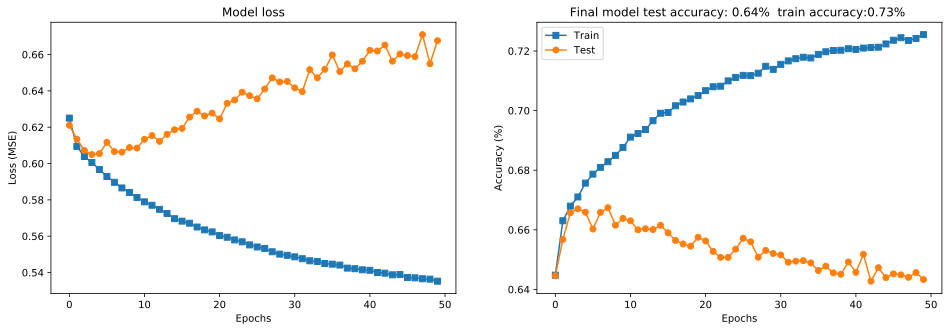

In [22]:
#Train the source model on numbers and show the results
# create a new model
net,lossfun,optimizer = DNA_RNA_Model3()

# train it on numbers data
trainAcc,testAcc,trainlosses,testlosses,numberNet = function3Merge(net,DNA_train_loader,DNA_test_loader,pssm_train_loader,pssm_test_loader,50)

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainlosses,'s-',label= 'Train')
ax[0].plot(testlosses,'o-',label= 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%  train accuracy:{trainAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()

tensor([[[-0.6817,  0.4061,  0.3627],
         [-0.2270, -0.2108,  0.0010],
         [ 0.4879, -0.1750, -0.1614]]], grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)
numberNet TRAIN accuracy: 1.00%
numberNet TEST accuracy: 1.00%


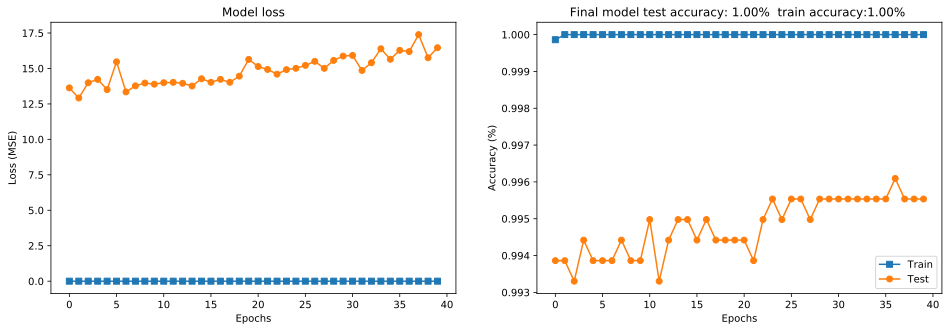

In [49]:
#Transfer LEarning with miRNA

## NOTE about this cell: I've added print() statements in here to show that the copying works.
## The first print function will show a non-zeros matrix because the weights of the two models
## differ. The second print function shows the zeros matrix because the two models have identical
## weights. See Q&A for this lecture.

# create the target model
miRNANet,loss,optimizer =DNA_RNA_Model3()
print( miRNANet.conv1.weight[0] - net.conv1.weight[0] )

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(miRNANet.named_parameters(),net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print( miRNANet.conv1.weight[0] - net.conv1.weight[0] )

# now re-train the network on the numbers data

trainAcc,testAcc,trainlosses,testlosses,fashionNet= function2Merge( miRNANet,DNA_train_loader,DNA_test_loader,pssm_train_loader,pssm_test_loader,40)

print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainlosses,'s-',label= 'Train')
ax[0].plot(testlosses,'o-',label= 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%  train accuracy:{trainAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()



In [ ]:
# extract X,y from FASHION test dataloader
X,y = next(iter(miRNA_test_loader))
a,b = next(iter(pssm_train_loader))
yHat = net(X,a)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float())

print(f'NUMBERNET performance on miRNA data: {fashionAcc:.2f}%')